In [25]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
import pickle

ModuleNotFoundError: No module named 'sklearn'

### Regressive Modeling

In [14]:
def generate_supervised(data):
    supervised = data.copy()
    
    # Creating column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised[col_name] = supervised['sales_diff'].shift(i)
    
    # Dropping null values
    supervised = supervised.dropna().reset_index(drop=True)
    
    supervised.to_csv('../data/input/model.csv', index=False)
    
    return supervised

In [15]:
stationary = pd.read_csv('../data/input/stationary.csv')
model_df = generate_supervised(stationary)

### ARIMA Modeling

In [16]:
def generate_arima_data(data):
    dt_data = data.set_index('orderDate').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    dt_data.to_csv('../data/output/arima.csv')
    
    return dt_data

In [17]:
datetime_df = generate_arima_data(stationary)
datetime_df

,Unnamed: 0,sales_diff
orderDate,,
2002-01-10,1,-234.1440
2002-01-11,2,-1088.3000
2002-01-12,3,1436.6320
2002-01-13,4,7199.3870
2002-01-14,5,-7630.7610
...,...,...
2002-09-05,360,3677.6590
2002-09-06,361,-4123.1850
2002-09-07,362,4112.9720


#### Loading the ARIMA Data

In [18]:
def load_data():
    return pd.read_csv('../data/output/arima.csv').set_index('orderDate')

arm_data = load_data()

In [19]:
arm_data.index = pd.to_datetime(arm_data.index)

### SARIMAX Modeling

In [20]:
def get_scores(data):
    
    model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.forecast[-12:]))
    mae = mean_absolute_error(data.sales_diff[-12:], data.forecast[-12:])
    r2 = r2_score(data.sales_diff[-12:], data.forecast[-12:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
    pickle.dump(model_scores, open( "arima_model_scores.p", "wb" ))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.57199D+00    |proj g|=  6.11029D-03

At iterate    5    f=  9.57194D+00    |proj g|=  6.88095D-04

At iterate   10    f=  9.57193D+00    |proj g|=  6.01846D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     11     14      1     0     0   5.868D-05   9.572D+00
  F =   9.5719346708985942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


NameError: name 'mean_squared_error' is not defined

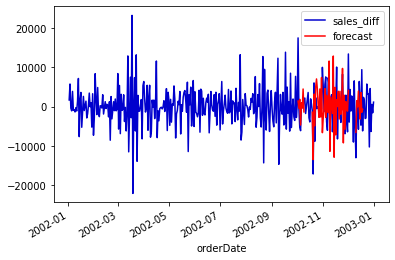

In [23]:
def sarimax_model(data):
    # Model
    sar = sm.tsa.statespace.SARIMAX(arm_data.sales_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()

    # Predictions
    start, end, dynamic = 40, 100, 7
    data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start+dynamic:end]
    
    data[['sales_diff', 'forecast']].plot(color=['mediumblue', 'Red'])
    
    get_scores(data)

    return sar, data, pred_df

sar, arm_data, predictions = sarimax_model(arm_data)

In [24]:
sar.plot_diagnostics(figsize=(10, 8));

NameError: name 'sar' is not defined

### Conclusion

In [ ]:
def predict_df(prediction_df):
    
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('../data/input/train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('orderDate')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(prediction_df)):
        result_dict = {}
        result_dict['pred_value'] = int(prediction_df[index] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result, original_df

In [ ]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Orders",
           title = f"{model_name} Order Forecaster")
    
    ax.legend()
    
    sns.despine()
    

    plt.savefig(f'../model_output/{model_name}_forecast.png')

In [ ]:
prediction_df, original_df = predict_df(predictions)
plot_results(prediction_df, original_df, 'arima')

### References

- https://www.studytonight.com/post/what-is-mean-squared-error-mean-absolute-error-root-mean-squared-error-and-r-squared
- 